# If runnning on Collab, import datasets on drive and run next cells:

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
df_juliet = pd.read_csv('/content/drive/My Drive/juliet.csv')

In [ ]:
df_natural = pd.read_csv('/content/drive/My Drive/real-world.csv')

# If not running on Collab, run this cells:

In [ ]:
df_juliet = pd.read_csv('juliet.csv')

In [ ]:
df_natural = pd.read_csv('real-world.csv')

# MAKING ASTs for real-world cases

In [ ]:
import pandas as pd
from pycparser import c_parser, c_ast
import re

parser = c_parser.CParser()

def preprocess(expression: str):
    """Removes comments, preprocessor directives, and replaces size_t/ssize_t with appropriate types."""
    # Remove comments (single-line and multi-line)
    expression = re.sub(r'//.*?\n|/\*.*?\*/', '', expression, flags=re.S)

    # Remove lines starting with #
    expression = re.sub(r'^\s*#.*$', '', expression, flags=re.MULTILINE)

    # Replace size_t with unsigned int
    expression = re.sub(r'\bsize_t\b', 'unsigned int', expression)

    # Replace ssize_t with int
    expression = re.sub(r'\bssize_t\b', 'int', expression)

    expression = re.sub(r'\bbool\b', 'int', expression)

    return expression.strip()


def convert_to_ast(expression: str):
    try:
        expression_processed = preprocess(expression)
        ast = parser.parse(expression_processed)
        return ast
    except Exception as e:
        print(f"Error parsing expression: {e}, {expression_processed}")
        return None

df_natural['ast'] = df_natural['func'].apply(convert_to_ast)

Streaming output truncated to the last 5000 lines.
    pt_thaw_time(v);

    pt_vcpu_unlock(v);
}
Error parsing expression: :9:9: before: migrate_timer, void pt_migrate(struct vcpu *v)
{
    struct list_head *head = &v->arch.hvm.tm_list;
    struct periodic_time *pt;

    pt_vcpu_lock(v);

    list_for_each_entry ( pt, head, list )
        migrate_timer(&pt->timer, v->processor);

    pt_vcpu_unlock(v);
}
Error parsing expression: :12:9: before: if, void pt_save_timer(struct vcpu *v)
{
    struct list_head *head = &v->arch.hvm.tm_list;
    struct periodic_time *pt;

    if ( v->pause_flags & VPF_blocked )
        return;

    pt_vcpu_lock(v);

    list_for_each_entry ( pt, head, list )
        if ( !pt->do_not_freeze )
            stop_timer(&pt->timer);

    pt_freeze_time(v);

    pt_vcpu_unlock(v);
}
Error parsing expression: :1:11: before: *, fz_pixmap *
fz_new_pixmap(fz_context *ctx, fz_colorspace *colorspace, int w, int h, fz_separations *seps, int alpha)
{
	int stride;
	int s = 

In [ ]:
df_test_natural = df_natural[df_natural['ast'].notna()]

# MAKING 30.000 - 30.000 SPLIT FOR JULIET DATASET

In [ ]:
df_good = df_juliet[df_juliet['ast'].str.contains("FileAST")]

In [ ]:
df_true = df_good[df_good['is_vuln'] == True].sample(n=30000, random_state=42)
df_false = df_good[df_good['is_vuln'] == False].sample(n=30000, random_state=42)

df_test_juliet = pd.concat([df_true, df_false]).reset_index(drop=True)

In [ ]:
df_test_juliet_subset = df_test_juliet[['function_code_generic', 'is_vuln', 'ast']].copy()
df_test_juliet_subset.columns = ['func', 'target', 'ast']

df_test_natural_subset = df_test_natural[['func', 'target', 'ast']].copy()

df_test = pd.concat([df_test_juliet_subset, df_test_natural_subset], ignore_index=True)

In [ ]:
print(df_test.shape)

(69235, 3)


# TRAINING CLASSICAL ML MODELS

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

def run_text_classification_experiments(df_test):
    from tqdm.notebook import tqdm
    tqdm.pandas()

    df_test['ast_str'] = df_test['ast'].apply(str)

    X = df_test['ast_str']
    y = df_test['target']

    vectorizers = {
        'Count': CountVectorizer(),
        'TFIDF': TfidfVectorizer(),
        'Hashing': HashingVectorizer(n_features=10000)
    }

    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'KNN': KNeighborsClassifier(),
        'LogReg L1': LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
        'LogReg L2': LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    for vec_name, vectorizer in tqdm(vectorizers.items(), desc="Vectorizers"):
        print(f"\n=== Using {vec_name} Vectorizer ===")
        X_vec = vectorizer.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

        for clf_name, clf in tqdm(classifiers.items(), desc=f"{vec_name} Classifiers", leave=False):
            print(f"\n--- Classifier: {clf_name} ---")
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(classification_report(y_test, y_pred))

In [ ]:
run_text_classification_experiments(df_test)

# RUN CNN + LSTM MODEL

In [ ]:
df_test['ast_str'] = df_test['ast'].astype(str)
X_raw = df_test['ast_str']
y = df_test['target'].astype(int)
max_words = 256
max_len = 500

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_raw)
sequences = tokenizer.texts_to_sequences(X_raw)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam


def run_cnn_lstm_model(df_test, max_words=256, max_len=500, embedding_dim=64, epochs=10):
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, y, test_size=0.2, random_state=42
    )

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        Conv1D(filters=512, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    return model, history

In [ ]:
model, history = run_cnn_lstm_model(df_test)

Epoch 1/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1049s 1s/step - accuracy: 0.5811 - loss: 0.6727 - val_accuracy: 0.5689 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 2/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1103s 1s/step - accuracy: 0.5790 - loss: 0.6718 - val_accuracy: 0.6999 - val_loss: 0.5760 - learning_rate: 0.0010
Epoch 3/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1102s 1s/step - accuracy: 0.7326 - loss: 0.5047 - val_accuracy: 0.7826 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 4/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1088s 1s/step - accuracy: 0.7851 - loss: 0.3974 - val_accuracy: 0.8043 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 5/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1042s 1s/step - accuracy: 0.8072 - loss: 0.3602 - val_accuracy: 0.8126 - val_loss: 0.3462 - learning_rate: 0.0010
Epoch 6/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1049s 1s/step - accuracy: 0.8215 - loss: 0.3280 - val_accuracy: 0.8283 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 7/10
779/779 ━━━━━━━━━━━━━━━━━━━━ 1091s 1s/step - accuracy: 0.8293 - l

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


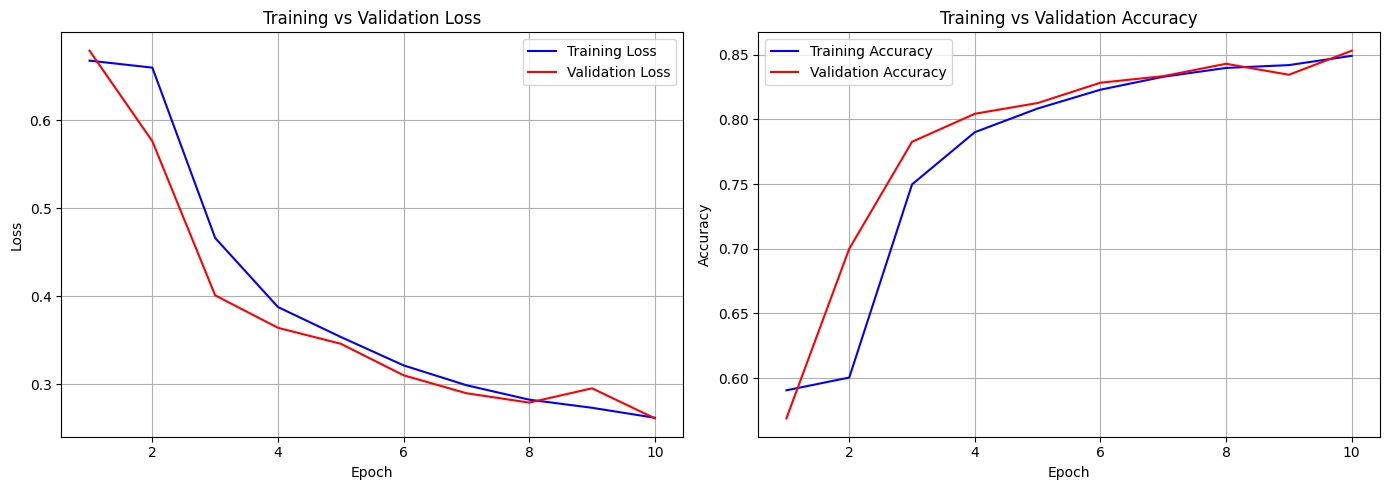

In [ ]:
plot_training_history(history)

# TRAIN GNNs with CFGs

In [ ]:
import pandas as pd
from pycparser import c_parser, c_ast
import re

parser = c_parser.CParser()

def preprocess(expression: str):
    """Removes comments, preprocessor directives, and replaces size_t/ssize_t with appropriate types."""
    # Remove comments (single-line and multi-line)
    expression = re.sub(r'//.*?\n|/\*.*?\*/', '', expression, flags=re.S)

    # Remove lines starting with #
    expression = re.sub(r'^\s*#.*$', '', expression, flags=re.MULTILINE)

    # Replace size_t with unsigned int
    expression = re.sub(r'\bsize_t\b', 'unsigned int', expression)

    # Replace ssize_t with int
    expression = re.sub(r'\bssize_t\b', 'int', expression)

    expression = re.sub(r'\bbool\b', 'int', expression)

    return expression.strip()

def convert_to_ast(expression: str):
    try:
        expression_processed = preprocess(expression)
        ast = parser.parse(expression_processed)
        return ast
    except Exception as e:
        print(f"Error parsing expression: {e}, {expression_processed}")
        return None

df_test_natural['ast'] = df_test_natural['func'].apply(convert_to_ast)

<ipython-input-29-ce87303082e3>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_natural['ast'] = df_test_natural['func'].apply(convert_to_ast)


In [ ]:
from pycparser import c_parser
import re
from tqdm import tqdm

parser = c_parser.CParser()
asts = []

typedef_fix = "typedef unsigned int size_t;\n"
typedef_file = "typedef struct _FILE FILE;\n"
typedef_handle = "typedef struct _HANDLE HANDLE;\n"
typedef_hwinsta = "typedef struct _HWINSTA HWINSTA;\n"
typedef_bool = "typedef int BOOL;\n"


for code in tqdm(df_test_juliet['function_code']):
    try:
        clean_code = re.sub(r'//.*?$|/\*.*?\*/', '', code, flags=re.DOTALL | re.MULTILINE)
        clean_code = re.sub(r'WSADATA', 'struct WSADATA', clean_code)
        clean_code = re.sub(r'SOCKET', 'int', clean_code)
        clean_code = re.sub(r'INVALID_SOCKET', '-1', clean_code)
        clean_code = re.sub(r'wchar_t', 'char', clean_code)
        clean_code = re.sub(r'int64_t', 'int', clean_code)
        clean_code = re.sub(r'twoIntsStruct', 'struct', clean_code)
        clean_code = re.sub(r'structSigAtomic', 'struct', clean_code)
        clean_code = re.sub(r'^.*CWE.* myStruct;$', 'struct myStruct;', clean_code, flags=re.MULTILINE)
        clean_code = re.sub(r'^.*CWE.* myUnion;$', 'union myUnion;', clean_code, flags=re.MULTILINE)
        clean_code = '\n'.join(line for line in clean_code.splitlines() if not line.strip().startswith('#'))
        clean_code = typedef_fix + typedef_file + typedef_handle + typedef_hwinsta + typedef_bool + clean_code

        ast = parser.parse(clean_code)
        asts.append(ast)
    except Exception as e:
        asts.append(str(e) + '\n' + clean_code)

df_test_juliet['ast'] = asts

100%|██████████| 60000/60000 [04:15<00:00, 234.95it/s]


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [ ]:
from pycparser import c_ast
from torch_geometric.data import Data
import torch

def pycparser_ast_to_graph(ast_root):
    nodes = []
    edges = []

    def visit(node, parent_idx):
        cur_idx = len(nodes)
        nodes.append(node)
        if parent_idx is not None:
            edges.append((parent_idx, cur_idx))
        for child_name, child in node.children():
            visit(child, cur_idx)

    visit(ast_root, None)

    node_types = list(set(type(n).__name__ for n in nodes))
    type_to_idx = {t: i for i, t in enumerate(node_types)}
    x = torch.tensor([[type_to_idx[type(n).__name__]] for n in nodes], dtype=torch.float)

    if len(edges) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

In [ ]:
graph_list = []

for ast_tree, label in zip(df_test['ast'], df_test['target']):
    try:
        data = pycparser_ast_to_graph(ast_tree)
        data.y = torch.tensor([label])
        graph_list.append(data)
    except Exception as e:
        print("Error converting AST:", e)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def ast_to_graph(ast_root, type_to_idx):
    nodes = []
    edges = []

    def visit(node, parent_idx):
        cur_idx = len(nodes)
        nodes.append(node)
        if parent_idx is not None:
            edges.append((parent_idx, cur_idx))
        for _, child in node.children():
            visit(child, cur_idx)

    visit(ast_root, None)

    node_indices = [type_to_idx[type(n).__name__] for n in nodes]
    x = F.one_hot(torch.tensor(node_indices), num_classes=len(type_to_idx)).float()
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

all_types = set()
for tree in df_test['ast']:
    def collect_types(node):
        all_types.add(type(node).__name__)
        for _, child in node.children():
            collect_types(child)
    collect_types(tree)

type_to_idx = {t: i for i, t in enumerate(sorted(all_types))}

graph_list = []
for tree, label in zip(df_test['ast'], df_test['target']):
    try:
        data = ast_to_graph(tree, type_to_idx)
        data.y = torch.tensor([label], dtype=torch.long)
        graph_list.append(data)
    except Exception as e:
        print("AST error:", e)

labels = [d.y.item() for d in graph_list]
train_graphs, val_graphs = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)

weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(weights, dtype=torch.float)

class GCN_LSTM_Dropout(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, lstm_hidden_size, num_layers=3, out_channels=2, dropout=0.5):
        super(GCN_LSTM_Dropout, self).__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.gcn_dropout = torch.nn.Dropout(dropout)
        self.lstm = torch.nn.LSTM(hidden_channels, lstm_hidden_size, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(lstm_hidden_size, out_channels)
        self.fc_dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index).relu()
        x = self.gcn_dropout(x)
        x = global_mean_pool(x, batch)
        x = x.unsqueeze(1)
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # hn[-1] is the final hidden state of the LSTM
        out = self.fc_dropout(out)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_LSTM_Dropout(in_channels=len(type_to_idx), hidden_channels=512, lstm_hidden_size=256, num_layers=3, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

early_stopping_patience = 10
best_val_f1 = 0
epochs_without_improvement = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, 50):
    model.train()
    total_train_loss = 0
    all_train_preds, all_train_labels = [], []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()

        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels)

    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds, zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_preds, zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=0)

    model.eval()
    total_val_loss = 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)
            total_val_loss += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            all_val_preds.extend(preds)
            all_val_labels.extend(labels)

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_acc)
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_gcn_lstm_dropout_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

    scheduler.step(total_val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {total_train_loss:.4f} | Train Acc: {train_acc:.2f} | "
          f"Val Loss: {total_val_loss:.4f} | Val Acc: {val_acc:.2f} | Train F1: {train_f1:.2f} | "
          f"Val F1: {val_f1:.2f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy', color='red', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | Train Loss: 1080.4055 | Train Acc: 0.65 | Val Loss: 246.7012 | Val Acc: 0.70 | Train F1: 0.66 | Val F1: 0.70
Epoch 02 | Train Loss: 969.8688 | Train Acc: 0.69 | Val Loss: 223.5741 | Val Acc: 0.73 | Train F1: 0.71 | Val F1: 0.76
Epoch 03 | Train Loss: 913.6244 | Train Acc: 0.72 | Val Loss: 213.2104 | Val Acc: 0.74 | Train F1: 0.74 | Val F1: 0.75
Epoch 04 | Train Loss: 868.8558 | Train Acc: 0.73 | Val Loss: 200.8814 | Val Acc: 0.75 | Train F1: 0.75 | Val F1: 0.77
Epoch 05 | Train Loss: 823.1023 | Train Acc: 0.75 | Val Loss: 184.7132 | Val Acc: 0.78 | Train F1: 0.76 | Val F1: 0.80
Epoch 06 | Train Loss: 775.3342 | Train Acc: 0.76 | Val Loss: 183.7928 | Val Acc: 0.77 | Train F1: 0.77 | Val F1: 0.77
Epoch 07 | Train Loss: 744.8944 | Train Acc: 0.77 | Val Loss: 170.0464 | Val Acc: 0.79 | Train F1: 0.77 | Val F1: 0.80
Epoch 08 | Train Loss: 720.6357 | Train Acc: 0.77 | Val Loss: 164.9987 | Val Acc: 0.80 | Train F1: 0.78 | Val F1: 0.80
Epoch 09 | Train Loss: 703.8657 | Train Acc: 0.

KeyboardInterrupt: 

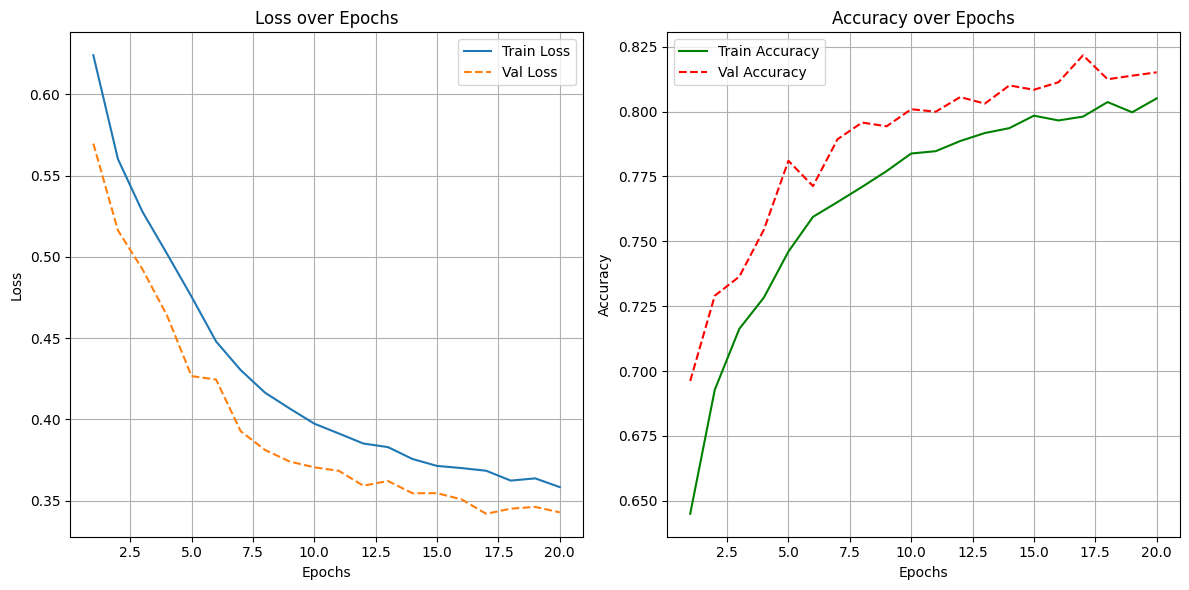

In [ ]:
# plt.figure(figsize=(12, 6))

# # Plot Training Loss and Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', linestyle='--')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.legend()

# # Plot Training Accuracy and Validation Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='green')
# plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy', color='red', linestyle='--')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.legend()

# plt.tight_layout()
# plt.show()